# 1. Dataset load

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, StratifiedKFold, learning_curve
from sklearn.pipeline import Pipeline
from scipy import stats
from scipy.stats import norm, skew

# train / test set load
train = pd.read_csv("../FIFA_train.csv")
test = pd.read_csv("../FIFA_test.csv")


In [2]:
# dataset info
train.info() # (8932, 12)
test.info()  # (3828, 11)
train.describe()
train["source"] = "train"
test["source"] = "test"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8932 non-null   int64  
 1   name              8932 non-null   object 
 2   age               8932 non-null   int64  
 3   continent         8932 non-null   object 
 4   contract_until    8932 non-null   object 
 5   position          8932 non-null   object 
 6   prefer_foot       8932 non-null   object 
 7   reputation        8932 non-null   float64
 8   stat_overall      8932 non-null   int64  
 9   stat_potential    8932 non-null   int64  
 10  stat_skill_moves  8932 non-null   float64
 11  value             8932 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 837.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3828 entries, 0 to 3827
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------      

In [3]:
# dataset check
train.head()

# 연속형 변수 / 범주형변수 분리
'''
연속형 변수 : 'age',  'stat_overall', 'stat_potential'
범주형 변수 : 'continent', 'contract_until', 'position', 'prefer_foot', 'reputation'
'id', 'name', 'value', stat_skill_moves
'''
train.columns

train["stat_skill_moves"]

0       4.0
1       1.0
2       3.0
3       3.0
4       1.0
       ... 
8927    3.0
8928    2.0
8929    2.0
8930    1.0
8931    2.0
Name: stat_skill_moves, Length: 8932, dtype: float64

In [4]:
import re
train[["contract_until", "value"]].groupby("contract_until").count()

,value
contract_until,
2018,327
2019,2366
2020,2041
2021,2308
2022,761
2023,506
2024,12
2025,3
2026,1


In [5]:
comdata = pd.concat([train, test], ignore_index=True)

In [6]:
# contract_until 변수 전처리(월, 일 제거)
idx = []
for i, value in enumerate(comdata["contract_until"]):
    if re.match("[A-Z]{1,}", value):
        idx.append(i)
comdata["contract_until"][idx].replace("[A-Z]{1,}[a-z]{2}", "")

for i, j in zip(comdata["contract_until"][idx], idx):
    comdata["contract_until"][j] = re.sub("[A-Z]{1,}[a-z]{2} [0-9]{1,}, ", "", i).strip()
    
# 공백 제거
comdata.loc[:, "contract_until"] = comdata.loc[:, "contract_until"].str.strip()

/Users/mac/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


               value              
               count          mean
contract_until                    
2018             391  1.286407e+06
2019            2899  1.746123e+06
2020            2051  2.397036e+06
2021            2308  2.827543e+06
2022             761  5.899074e+06
2023             506  5.802115e+06
2024              12  2.450833e+07
2025               3  1.405333e+07
2026               1  5.050000e+07


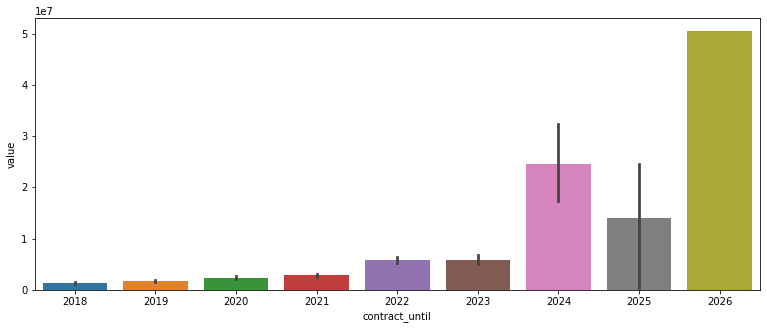

In [7]:
# contract_until 
# 변수에 따라 선수가치가 변하므로 사용!
fig = plt.subplots( figsize = (13,5))
sns.barplot(x = "contract_until", y = "value", data = comdata)

print(comdata[["contract_until", "value"]].groupby(["contract_until"]).agg(["count", "mean"]))
comdata.loc[comdata["contract_until"] == "2025", "contract_until"] = "2024"
comdata.loc[comdata["contract_until"] == "2026", "contract_until"] = "2024"

# 2024년 이상 계약기간의 선수의 수는 작으므로 2024로통일

value      
                       mean count
continent                        
africa         2.972247e+06   721
asia           1.035146e+06   787
europe         2.928125e+06  5322
oceania        8.225429e+05   175
south america  3.183204e+06  1927

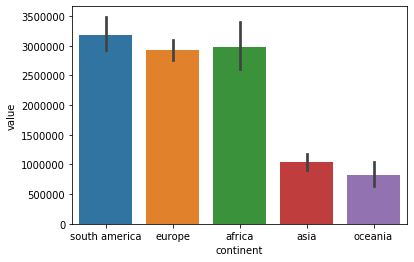

In [8]:
# continent
g = sns.barplot(x = "continent", y = "value", data = comdata)
comdata[["continent", "value"]].groupby(["continent"]).agg(["mean", "count"])

value      
                  mean count
position                    
DF        2.304348e+06  2791
GK        1.992073e+06  1008
MF        3.121762e+06  3428
ST        3.330361e+06  1705

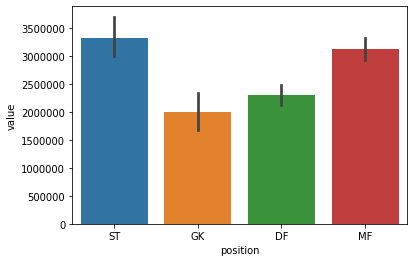

In [9]:
# position
g = sns.barplot(x = "position", y = "value", data = comdata)
comdata[["position", "value"]].groupby(["position"]).agg(["mean", "count"])

                    value      
                     mean count
prefer_foot                    
left         2.865232e+06  2095
right        2.752150e+06  6837


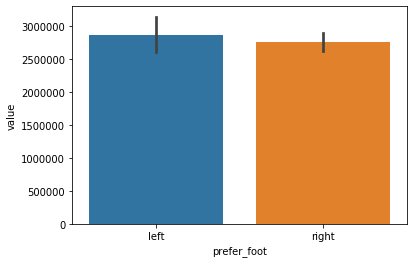

In [10]:
# prefer_foot
g = sns.barplot(x = "prefer_foot", y = "value", data = comdata)
print(comdata[["prefer_foot", "value"]].groupby(["prefer_foot"]).agg(["mean", "count"]))

# ttest로 평균차이 확인
prefter_left = comdata.loc[comdata["prefer_foot"] == "left", "value"]
prefter_left = prefter_left.dropna()

prefter_right = comdata.loc[comdata["prefer_foot"] == "right", "value"]
prefter_right = prefter_right.dropna()

stats.ttest_ind(prefter_left, prefter_right)
# pvalue > 0.05, 왼발과 오른발에는 평균에는 차이가 없다.
# 오른발 = 0, 왼발 = 1로 분류
comdata["prefer_foot"] = comdata["prefer_foot"].replace(["right", "left"], [0, 1])

                   value      
                    mean count
reputation                    
1.0         1.690092e+06  8014
2.0         8.639221e+06   706
3.0         2.201483e+07   177
4.0         3.342903e+07    31
5.0         6.062500e+07     4
[5. 4. 3. 1. 2.]


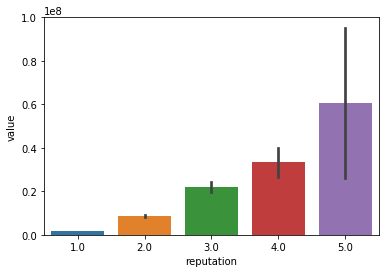

In [11]:
# reputation
g = sns.barplot(x = "reputation", y = "value", data = comdata)
print(comdata[["reputation", "value"]].groupby(["reputation"]).agg(["mean", "count"]))
print(comdata["reputation"].unique())
comdata["reputation"] = comdata["reputation"].astype("category")

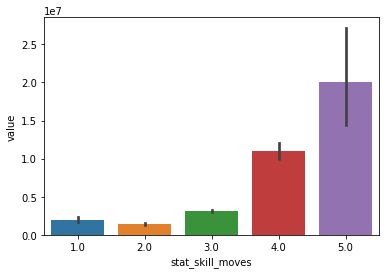

In [12]:
# stat_skill_moves
g = sns.barplot(x = "stat_skill_moves", y = "value", data = comdata)
comdata["stat_skill_moves"] = comdata["stat_skill_moves"].astype("category")

<Figure size 576x432 with 0 Axes>

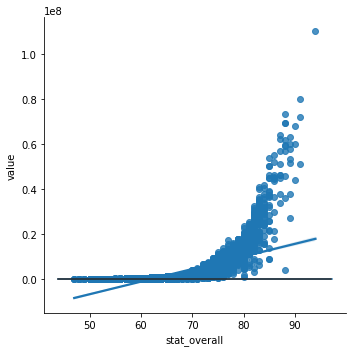

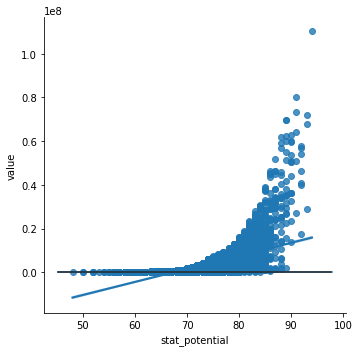

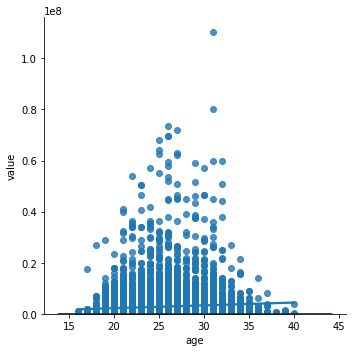

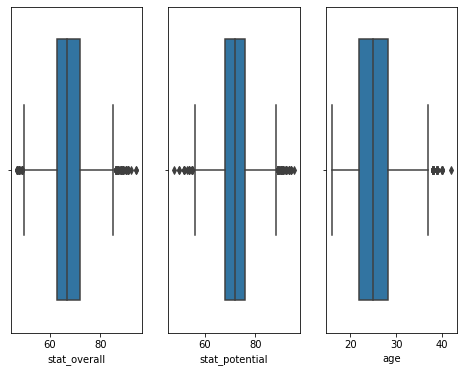

In [13]:
# 연속형변수 확인
# 'age', 'stat_overall', 'stat_potential'
# 스케일링
ind_idx_num = ['stat_overall', 'stat_potential', "age"]
de_idx = "value"


plt.figure(figsize  = (8, 6))
for i in ind_idx_num:
    sns.lmplot(x = i, y = "value", data = comdata)
    sns.distplot(comdata[i], fit = norm)

fig, ax = plt.subplots(ncols = 3, figsize  = (8, 6))

for i, j in enumerate(ind_idx_num):
    sns.boxplot(x = comdata[j], ax = ax[i])
# 다수의 이상치 존재

In [14]:
# 회귀분석에 필요하지 않는 변수 제거
# id, name drop
comdata.drop(labels = ["id", "name"], axis = 1, inplace=True)

In [15]:
#  train, test set 분리
train = comdata[comdata["source"] == "train"].drop("source", axis=1)
real_test = comdata[comdata["source"] == "test"].drop("source", axis=1)

# 이상치는 RobustScaler 활용을 통해 표준화해서 값 사용
scaler = RobustScaler()
scaled = scaler.fit_transform(train[["stat_overall", "stat_potential", "age"]])

train["stat_overall"] = scaled[:,0]
train["stat_potential"] = scaled[:,1]
train["age"] = scaled[:,2]

scaled_rel = scaler.transform(real_test[["stat_overall", "stat_potential", "age"]])

real_test["stat_overall"] = scaled_rel[:,0]
real_test["stat_potential"] = scaled_rel[:,1]
real_test["age"] = scaled_rel[:,2]

In [16]:
# One-Hot-encoding 더미변수 생성
train_dummy = pd.get_dummies(train)
real_test_dummy = pd.get_dummies(real_test)

In [17]:
# 독립변수, 종속변수 분리
col = train_dummy.columns
y_col = "value"
x_col = [i for i in col if i != y_col]

# train /test set split
x_train, x_test, y_train, y_test = train_test_split(train_dummy[x_col], train_dummy[y_col], test_size = 0.3)


/Users/mac/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/Users/mac/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/Users/mac/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/Users/mac/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/Users/mac/opt/anaconda3/lib/python3.7/site-packages/sklearn

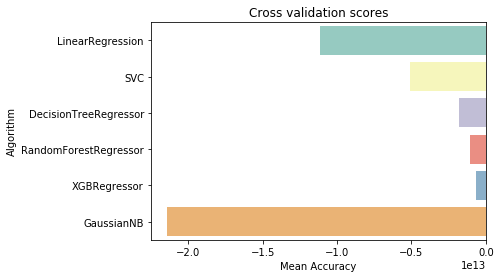

In [71]:
# Modeling differents algorithms. 
kfold = StratifiedKFold(n_splits=10)
random_state = 2
regressors = []

regressors.append(LinearRegression())
regressors.append(SVC(kernel="linear", random_state = random_state))
regressors.append(DecisionTreeRegressor(random_state=random_state))
regressors.append(RandomForestRegressor(random_state=random_state))
regressors.append(XGBRegressor(random_state=random_state))
regressors.append(GaussianNB())


cv_results = []
for regressor in regressors :
    cv_results.append(cross_val_score(regressor, x_train, y = y_train, cv = kfold, n_jobs=4, scoring="neg_mean_squared_error"))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,
                       "Algorithm":["LinearRegression",
                                    "SVC",
                                    "DecisionTreeRegressor",
                                    "RandomForestRegressor",
                                    "XGBRegressor",
                                    "GaussianNB",]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h")
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

,CrossValMeans,CrossValerrors,Algorithm
0,-1.112615e+13,2.516829e+12,LinearRegression
1,-5.109034e+12,1.446614e+12,SVC
2,-1.804033e+12,1.536349e+12,DecisionTreeRegressor
3,-1.033246e+12,8.218295e+11,RandomForestRegressor
4,-6.802111e+11,4.466274e+11,XGBRegressor
5,-2.143955e+13,5.302654e+12,GaussianNB


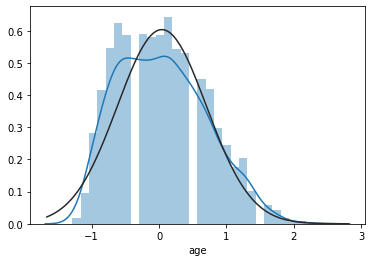

In [77]:
cv_res

In [ ]:
# 기본 pipe 생성
pipe = Pipeline([("regressor", RandomForestRegressor())])

# paramgrid
param_grid = [{"regressor":[RandomForestRegressor()], "regressor__n_estimators":[100,200,300],
             "regressor__max_depth":[3,6,8], "regressor__min_samples_split":[2,3,4,5], "regressor__min_samples_leaf": [1,3,5,7]},
             {"regressor":[XGBRegressor()], "regressor__colsample_bylevel":[0.6,0.8,1], "regressor__learning_rate":[0.01,0.1],
             "regressor__max_depth":[3,6,8], "regressor__min_child_weight":[1,3], "regressor__n_estimators":[100,200,300]}]


# eval_set = [(x_test, y_test)], eval_metric = "rmse", verbose = True
# eval_set : ensamble 모형에서 사용
gs = GridSearchCV(pipe, param_grid, cv = 5, n_jobs=-1, scoring = "neg_mean_squared_error")

model = gs.fit(x_train, y_train)

In [ ]:
# model score & best_parameter
print(model.best_score_)
print(model.best_estimator_)
y_pred = model.predict(x_test)
y_true = y_test
print(mean_squared_error(y_true, y_pred, squared = "False"))

In [23]:
# 모델기반 특성 선택
from sklearn.feature_selection import SelectFromModel

# GridSearch로 찾은 best parameter로 모델 생성 및 fit
select = SelectFromModel(XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=0.6, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=3,
                              n_estimators=300, n_jobs=0, num_parallel_tree=1,
                              objective='reg:squarederror', random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              validate_parameters=1, verbosity=None), threshold="median")
select.fit(x_train, y_train)
x_train_l1 = select.transform(x_train)
x_test_l1 = select.transform(x_test)

xgb = XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=0.6, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=3,
                              n_estimators=300, n_jobs=0, num_parallel_tree=1,
                              objective='reg:squarederror', random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              validate_parameters=1, verbosity=None)
model = xgb.fit(x_train_l1, y_train)
y_pred = model.predict(x_test_l1)
y_true = y_test
score = mean_squared_error(y_true, y_pred, squared = "False")
print(model.score(x_train_l1, y_train))
print(model.score(x_test_l1, y_test))
print("rmse score :", score)
# 276268410107.90094
# 363633401319.6854
# 375899270859.8781 age(스케일링)
# 294092435283.8894
# 1018174751259.2584
# 380040234463.18146
# 1376838319478.4944
# 1330987992728.7683

0.9965725333309372
0.9688665383620588
rmse score : 1330987992728.7683


In [ ]:
# 중요변수 확인 : 
model.best_estimator_.named_steps["regressor"].feature_importances_
plt.figure(figsize = (20,5))
sns.barplot(x = list(range(20)), y = model.best_estimator_.named_steps["regressor"].feature_importances_)
plt.xticks(list(range(20)), x_train.columns)
model.best_estimator_.named_steps["regressor"].feature_importances_

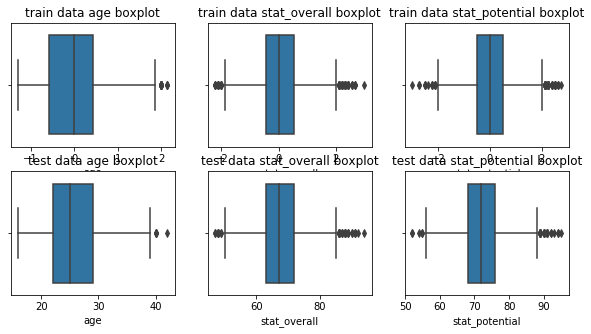

In [50]:
# 예측치 올리기 위한 전처리
index = ["age", "stat_overall", "stat_potential"]
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (10,5))


for idx, value in enumerate(index):
    g = sns.boxplot(train[value], ax = ax[0, idx])
    g.set_title(f"train data {value} boxplot", color = "black")
for idx, value in enumerate(index):
    g = sns.boxplot(test[value], ax = ax[1, idx])
    g.set_title(f"test data {value} boxplot", color = "black")

In [138]:
train_1q = train[index].describe().loc["25%"]
train_3q = train[index].describe().loc["75%"]
test_1q = test[index].describe().loc["25%"]
test_3q = test[index].describe().loc["75%"]

# IQR
# index = ["age", "stat_overall", "stat_potential"]
train_iqr = train_3q - train_1q
test_iqr = test_3q - test_1q

# 이상치 제거
idx_age = comdata[(comdata["age"] > train_iqr[0] + train_3q[0]) 
        | (comdata["age"] < train_1q[0] - train_iqr[0])]
idx_stat_overall= comdata[(comdata["stat_overall"] > train_iqr[1] + train_3q[1]) 
        | (comdata["stat_overall"] < train_1q[1] - train_iqr[1])]
idx_stat_overall[idx_stat_overall["source"] == "train"]

,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value,source
0,31,south america,2021,ST,1,5.0,94,94,4.0,110500000.0,train
1,27,europe,2020,GK,0,4.0,91,93,1.0,72000000.0,train
2,31,south america,2021,ST,0,5.0,91,91,3.0,80000000.0,train
3,32,europe,2020,DF,0,4.0,91,91,3.0,51000000.0,train
4,25,europe,2021,GK,0,3.0,90,93,1.0,68000000.0,train
...,...,...,...,...,...,...,...,...,...,...,...
8927,18,africa,2019,MF,0,1.0,48,63,3.0,60000.0,train
8928,19,europe,2020,DF,0,1.0,47,59,2.0,40000.0,train
8929,18,south america,2021,DF,0,1.0,47,64,2.0,50000.0,train
8930,18,europe,2021,GK,0,1.0,47,65,1.0,50000.0,train


In [21]:
# 실제 데이터 예측
rel_y_pred = model.predict(real_test_dummy[x_col])
real_test

submit = pd.read_csv("../submission.csv")
submit.info()
submit["value"] = rel_y_pred
submit.head()
submit.to_csv("../submission.csv", index = None, encoding = "utf-8")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3828 entries, 0 to 3827
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      3828 non-null   int64  
 1   value   3828 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 59.9 KB


In [ ]:
lgb = LGBMRegressor()
train_ds = lgb.Dataset(x_train, label = y_train) 
test_ds = lgb.Dataset(x_test, label = y_test) 

param_grid = {
    'n_estimators': [400, 700, 1000],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [15,20,25],
    'num_leaves': [50, 100, 200],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
    'min_split_gain': [0.3, 0.4],
    'subsample': [0.7, 0.8, 0.9],
    'subsample_freq': [20]
}

model = lgb.train(param_grid, train_ds, 1000, test_ds, verbose_eval=100, early_stopping_rounds=100)
predict_train = model.predict(x_train)
predict_test = model.predict(x_test)

mse = mean_squared_error(y_test, predict_test)
r2 = r2_score(y_test, predict_test)